# Personal Finance Exploratory Data Analysis

The goal of this notebook is to explore the data extracted from Reddit's Personal Finance subreddit, including information such as the title of the submissions, the date of submission, the flair (topic), etc. Using Natural Language Processing tools and data visualization, we aim to learn any obvious and underlying trends from the submission information. In particular, we want to observe whether the data can tell us any interesting details about the users who submitted the posts such as what financial issues they may be facing. 

In [70]:
# Begin by importing the relevant libraries and packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk import PorterStemmer
import string
import re
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import pyLDAvis
import pyLDAvis.gensim 
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import spacy

In [2]:
# Import the data
df = pd.read_csv(r'C:\Users\joshu\Downloads\Data\reddit\reddit_pf.csv', engine='python', index_col=[0])

In [3]:
# Top 10 most popular topics (flairs)
df.topic.value_counts()[0:10]

Debt          1256
Other         1205
Credit        1048
Investing      859
Retirement     824
Employment     724
Housing        709
Auto           560
Planning       526
Saving         524
Name: topic, dtype: int64

### Which are the most popular topics?

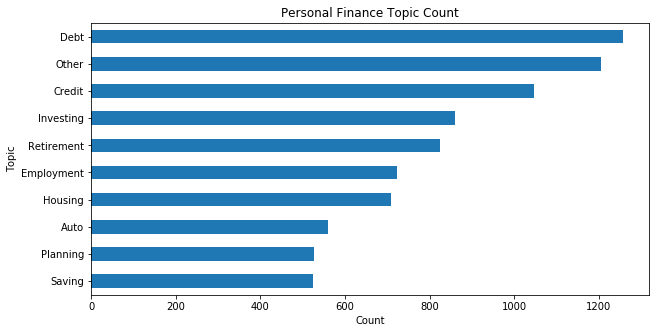

In [4]:
plt.figure(figsize = (10,5))
df.topic.value_counts()[0:10][::-1].plot(kind='barh')
plt.xlabel('Count')
plt.ylabel('Topic')
plt.title('Personal Finance Topic Count')
plt.show()

- Debt is the most popular topic in the personal finance subreddit, followed by Other and Credit. This indicates that debt is a major concern for many of the redditors (users) and they make submissions in order to seek advice.

- Other would include topics that don't match the default topics. With more data, it could be possible that Other is the most popular topic instead of Debt.

- Investment and Retirement are also similar in their counts while also being very similar in their functions.

- Let's look at the top 10 most popular submissions by sorting them by the number of upvotes.

In [5]:
# Top 10 most popular headlines
[title for title in df.sort_values(by='upvotes', ascending=False)['title'].values[:10]]

["IRS will allow employers to match their employees' student loan repayments",
 'Your amazon store card is probably scamming you',
 'So I fell for a scam yesterday and it still angers me.',
 'Wife passed away. I would truly appreciate some help figuring out where I stand.',
 'Bought a car today. Transmission went out 60 miles from the car lot and everyone had gone home for the day. Is there any chance I can get a refund?',
 'My girlfriend is being offered a too good to be true job with little to no personal history with employer.',
 'Do I need a credit card? I have been strongly advised against it by my parents who say its a scam and should be illegal but everything I look at says that no credit is just as bad if not worse than low credit. What should I do?',
 '[US] Paypal account balance is -$2000. What can they do?',
 'Why You Might Consider A Trade Over College (One Real-World Perspective)',
 '"Hidden" costs of buying a home and how to prepare for them.']

- There are a variety of different subjects in the top 10 most popular posts, ranging from scams to dealing with the loss of a family member.

- However, 3 of the top 10 include the word "scam", showing that this may be a popular subject in /r/personalfinance and could happen often. This could be a common issue among many people living in the US.

- While some posts are seeking advice, others provide advice such as '"Hidden" costs of buying a home and how to prepare for them.'

- Next let's tokenize the submission titles and drop stopwords to extract key words from the 20 most popular submissions. 

In [6]:
stopwords = set(stopwords.words('english'))

In [7]:
best_titles = df.sort_values(by='upvotes', ascending=False)['title'].values[:20]
best_words = set(np.concatenate([word_tokenize(t) for t in best_titles])) - stopwords
best_words = {word.lower() for word in best_words}
best_words = best_words - set(string.punctuation) - set(string.digits)

def is_float(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

best_words = {word for word in best_words if not is_float(word)}

best_words = {word for word in best_words if "'" not in word} 

In [10]:
pd.Series(index=list(best_words)[:25], data=[(df[df['title'].map(lambda title: word in title)]['upvotes'].mean(),
                                             df[df['title'].map(lambda title: word in title)]['upvotes'].count())
                                            for word in list(best_words)[:25]])

wife                     (119.984375, 64)
less                      (173.15625, 96)
card             (82.62051282051281, 585)
mother           (157.84615384615384, 52)
i              (34.810052852982416, 9271)
kids             (341.85714285714283, 21)
pay               (59.6839430894309, 984)
company          (55.21084337349398, 166)
stability                     (2292.0, 3)
financially       (160.5681818181818, 44)
would            (88.05555555555556, 144)
job              (33.63695652173913, 460)
security         (311.04347826086956, 23)
away             (267.24590163934425, 61)
girlfriend       (349.42857142857144, 28)
appreciate        (425.9310344827586, 29)
costs             (384.6818181818182, 22)
day             (231.27737226277372, 137)
1k              (25.128654970760234, 342)
essentially        (917.7142857142857, 7)
went                         (407.84, 25)
froze             (1068.6666666666667, 6)
100,000                       (2423.0, 3)
contributed                   (142

- As we can see, there are a lot of words that are very situational in nature such as "probably", "should", "might", "situation".

- Some words can give us an idea of what the topic is about such as "transmission", "scam", "fund", "employers".

- However other words are ambiguous and could have multiple implications such as "passed", "live", "lot", "account".



- Let's specifically look at cases where "passed" is in the title to observe its connotation and context in /r/personalfinance.

In [64]:
df[df['title'].map(lambda title: 'passed' in title)].head(10)

,title,date,time,upvotes,id,topic,clean_title,text_len
260,"Mum passed away a few years ago, looking for t...",2018-09-19,06:52 AM,0,9h445e,Investing,Mum passed away a few years ago looking for th...,74
1674,"[UK] 25, just entered into 5yr mortgage fixtur...",2018-09-16,05:38 AM,2,9g9e0r,Housing,UK just entered into yr mortgage fixture with...,160
1851,Dad passed in December. Mom lives in AZ and on...,2018-09-15,10:44 PM,1,9g7ays,Other,Dad passed in December Mom lives in AZ and onl...,75
2020,"Single dad w/ 4 kids, live with family for hel...",2018-09-15,03:28 PM,7105,9g47yh,Planning,Single dad w kids live with family for help w...,144
3207,"Dad passed away, evil stepmom did a 1035 excha...",2018-09-12,06:02 PM,1,9fc785,Insurance,Dad passed away evil stepmom did a exchange o...,113
3258,"Father passed away, mother not sure what to do.",2018-09-12,04:26 PM,1,9fbdod,Planning,Father passed away mother not sure what to do,39
3366,Can my previous employer withhold over $500 wo...,2018-09-12,01:44 PM,1,9f9y23,Employment,Can my previous employer withhold over worth ...,70
3452,Found out former employer passed on a negative...,2018-09-11,12:00 PM,1,9eytcu,Employment,Found out former employer passed on a negative...,50
3600,(UK) Father passed away in another country. No...,2018-09-11,08:16 AM,19,9ex0lb,Other,UK Father passed away in another country No id...,72
3741,My father recently passed and I have received ...,2018-09-11,03:27 PM,1,9f0k8q,Insurance,My father recently passed and I have received ...,97


- It's now clear that it is mostly used to sadly describe the passing away of a family member. 

- When looking at the topics, these submissions mostly fall under "Other" while the rest fall under a variety of topics such as Debt or Housing.



- Next let's tokenize the submissions using the word_tokenize() function and remove unnecessary characters (numbers, punctaation).

In [74]:
words_tokenized = [[w.lower() for w in word_tokenize(t)] for t in df['title']]
df['tokenized_title'] = words_tokenized
all_words = pd.Series(np.concatenate(words_tokenized)).value_counts()

In [75]:
stopwords = set(stopwords.words('english'))
all_words = all_words[[word not in stopwords for word in all_words.index]]
all_words = all_words[[word not in string.punctuation for word in all_words.index]]
all_words = all_words[[word not in string.digits for word in all_words.index]]
all_words = all_words[[not is_float(word) for word in all_words.index]]
all_words = all_words[["'" not in word for word in all_words.index]]

In [76]:
all_words[:10].index

Index(['credit', 'car', 'debt', 'need', 'card', 'money', 'help', 'loan',
       'advice', 'pay'],
      dtype='object')

### Which are the most popular tokens?

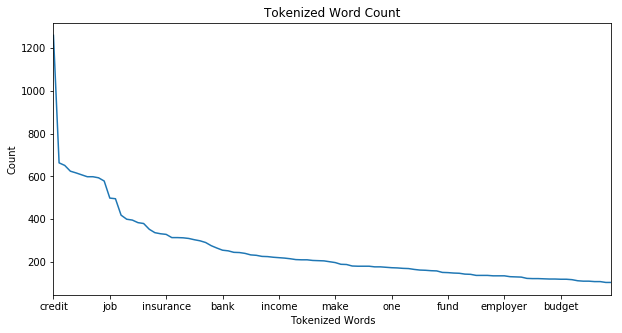

In [77]:
# Create a list of words evenly spread out by 10 in the top 100.
x = np.arange(0,100,10)
ten_words_list = []
for a in x:
    ten_words_list.append(all_words.index[a])

# Plot the words.
plt.figure(figsize = (10,5))
all_words[:100].plot()
plt.xticks(np.arange(0,100, 10), ten_words_list)
plt.xlabel('Tokenized Words')
plt.ylabel('Count')
plt.title('Tokenized Word Count')
plt.show()

### How does the popularity of posts change over time?

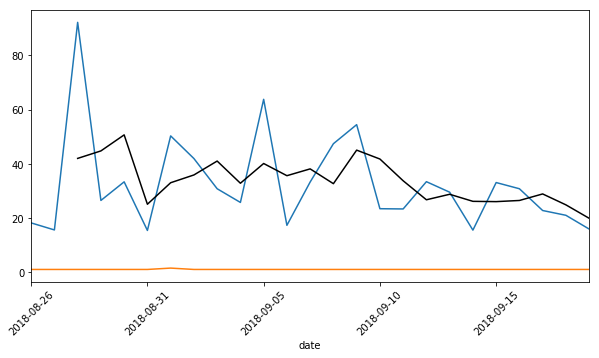

In [15]:
plt.figure(figsize=(10,5))
df.groupby('date')['upvotes'].mean().plot()
df.groupby('date')['upvotes'].median().plot()
df.groupby('date')['upvotes'].mean().rolling(window=3).mean().plot(color='black')
plt.xticks(rotation=45)
plt.show()

### What does the distribution of the title length look like?

In [42]:
# Create new column for text length
df['text_len'] = df['title'].apply(lambda x: len(x) - x.count(' '))
# Filter out the anomalies 
df = df[(df['topic'] != 'THIS IS A SPAMMER') & (df['topic'] != 'Meta')]

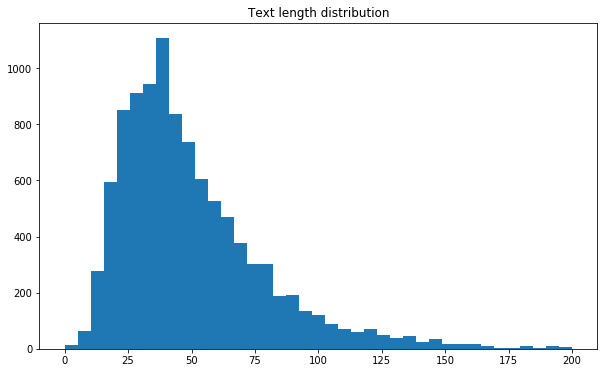

In [53]:
bins = np.linspace(0,200,40)
plt.figure(figsize=(10,6))
plt.hist(df['text_len'], bins)
plt.title('Text length distribution')
plt.show()

- Next, let's observe the distribution of the title lengths according to topic.

In [45]:
unique_topics = [x for x in df['topic'].unique() if x == x]

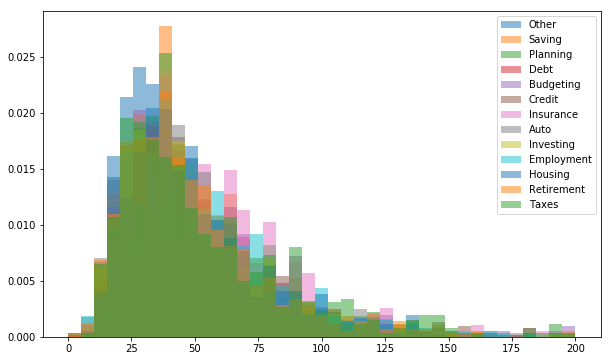

In [54]:
bins = np.linspace(0,200,40)

plt.figure(figsize=(10,6))
for topic in unique_topics:
    plt.hist(df[df['topic']==topic]['text_len'], bins, alpha = 0.5, density = True, label = topic)
plt.legend()
plt.show()

# Machine Learning

## Creating supervised topics using TF-IDF, Logistic Regression (Multi-class), Random Forest and Gradient Boosting.

In [71]:
# Begin by removing punctuation 
def remove_punct(text):
    text_nopunct = ''.join([char for char in text if char not in string.punctuation])
    return text_nopunct

df['clean_title'] = df['title'].apply(lambda x: remove_punct(x))

# Next remove digits
def remove_digits(text):
    text_nodigits = ''.join([char for char in text if char not in string.digits])
    return text_nodigits

df['clean_title'] = df['clean_title'].apply(lambda x: remove_digits(x))

In [72]:
# Import stemmer function
stemmer = PorterStemmer()

# Create a function that returns the stems of the tokens
def clean_text(text):
    text = ''.join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [stemmer.stem(word) for word in tokens if word not in stopwords]
    return text

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer(analyzer = clean_text)
X_tfidf = tfidf_vect.fit_transform(df['title'])
print(X_tfidf.shape)
print(tfidf_vect.get_feature_names())

## Creating unsupervised topics using Latent Dirichlet Allocation (LDA)

In [17]:
# Begin by removing punctuation 
def remove_punct(text):
    text_nopunct = ''.join([char for char in text if char not in string.punctuation])
    return text_nopunct

df['clean_title'] = df['title'].apply(lambda x: remove_punct(x))

# Next remove digits
def remove_digits(text):
    text_nodigits = ''.join([char for char in text if char not in string.digits])
    return text_nodigits

df['clean_title'] = df['clean_title'].apply(lambda x: remove_digits(x))

# Lowercase the words and tokenize using gensim's simple_preprocess function
def lowercase(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [18]:
# Turn the cleaned titles into a list
data_words = list(lowercase(df.clean_title))

In [19]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # Higher threshold results in fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

print(trigram_mod[bigram_mod[data_words[0]]])

C:\Users\joshu\Anaconda3\lib\site-packages\gensim\models\phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['ways', 'to', 'make', 'extra', 'side', 'money']


In [22]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stopwords] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [23]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['way', 'make', 'extra', 'side', 'money']]


In [24]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]]


In [25]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [26]:
from pprint import pprint
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.268*"pay" + 0.217*"get" + 0.069*"house" + 0.039*"sell" + 0.025*"keep" + '
  '0.018*"quit" + 0.016*"smart" + 0.015*"buying" + 0.015*"history" + '
  '0.013*"full"'),
 (1,
  '0.150*"buy" + 0.102*"look" + 0.099*"month" + 0.083*"mortgage" + '
  '0.071*"rent" + 0.047*"much" + 0.044*"know" + 0.016*"planning" + '
  '0.015*"housing" + 0.015*"inheritance"'),
 (2,
  '0.195*"year" + 0.119*"old" + 0.118*"take" + 0.042*"raise" + 0.037*"low" + '
  '0.024*"step" + 0.018*"health" + 0.016*"ne" + 0.014*"miss" + 0.013*"travel"'),
 (3,
  '0.154*"start" + 0.108*"first" + 0.103*"time" + 0.048*"ask" + 0.042*"auto" + '
  '0.040*"purchase" + 0.021*"chase" + 0.019*"part" + 0.014*"buyer" + '
  '0.014*"withdraw"'),
 (4,
  '0.210*"debt" + 0.124*"tax" + 0.102*"payment" + 0.063*"school" + '
  '0.027*"claim" + 0.021*"close" + 0.020*"place" + 0.019*"match" + '
  '0.016*"private" + 0.015*"value"'),
 (5,
  '0.240*"car" + 0.088*"score" + 0.073*"cash" + 0.044*"receive" + 0.039*"sure" '
  '+ 0.035*"situation" + 0.

In [27]:
# Compute Perplexity, which is a measure of how good the model is. The lower the better.
print('\nPerplexity: ', lda_model.log_perplexity(corpus)) 

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.109391806316372

Coherence Score:  0.5253025775263828


In [28]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
11     10.276570        1       1  0.433177  0.022666
0       5.999397        1       2 -0.005262 -0.019782
12      5.615802        1       3 -0.002053 -0.414806
10      5.599763        1       4 -0.006963  0.035910
16      5.498075        1       5 -0.016162  0.036779
14      5.350543        1       6 -0.007973 -0.010589
9       5.085576        1       7 -0.018617  0.012528
6       4.907628        1       8 -0.024035  0.031397
15      4.883367        1       9 -0.033408  0.027928
4       4.826252        1      10 -0.019730  0.026010
7       4.727605        1      11 -0.028155  0.031230
8       4.645859        1      12 -0.027383  0.027862
18      4.467363        1      13 -0.028628  0.015732
5       4.232797        1      14 -0.029651  0.028773
19      4.214686        1      15 -0.029258  0.027551
13      4.163277        1      16 -0.033048  0.026041
1       4.114716        1      17 -0.029240  0.018287
2       4.074465        1      18 -0.027214  0.020217
3       3.820328        1      19 -0.031774  0.023079
17      3.495934        1      20 -0.034624  0.033183, topic_info=     Category         Freq            Term        Total  loglift  logprob
term                                                                     
27    Default  1048.000000          credit  1048.000000  30.0000  30.0000
41    Default   955.000000             pay   955.000000  29.0000  29.0000
53    Default   840.000000            loan   840.000000  28.0000  28.0000
72    Default   774.000000             get   774.000000  27.0000  27.0000
37    Default   655.000000            need   655.000000  26.0000  26.0000
52    Default   605.000000             car   605.000000  25.0000  25.0000
36    Default   603.000000            debt   603.000000  24.0000  24.0000
87    Default   604.000000          advice   604.000000  23.0000  23.0000
7     Default   546.000000            help   546.000000  22.0000  22.0000
59    Default   578.000000            card   578.000000  21.0000  21.0000
9     Default   519.000000             job   519.000000  20.0000  20.0000
13    Default   472.000000            year   472.000000  19.0000  19.0000
2     Default   498.000000           money   498.000000  18.0000  18.0000
70    Default   496.000000         student   496.000000  17.0000  17.0000
144   Default   454.000000            good   454.000000  16.0000  16.0000
6     Default   401.000000              go   401.000000  15.0000  15.0000
74    Default   404.000000             new   404.000000  14.0000  14.0000
166   Default   367.000000             buy   367.000000  13.0000  13.0000
382   Default   350.000000           start   350.000000  12.0000  12.0000
15    Default   357.000000         account   357.000000  11.0000  11.0000
102   Default   357.000000             tax   357.000000  10.0000  10.0000
1     Default   339.000000            make   339.000000   9.0000   9.0000
245   Default   304.000000             not   304.000000   8.0000   8.0000
69    Default   328.000000        question   328.000000   7.0000   7.0000
128   Default   288.000000             old   288.000000   6.0000   6.0000
140   Default   285.000000            take   285.000000   5.0000   5.0000
68    Default   314.000000          option   314.000000   4.0000   4.0000
132   Default   299.000000       insurance   299.000000   3.0000   3.0000
32    Default   293.000000         payment   293.000000   2.0000   2.0000
182   Default   275.000000            work   275.000000   1.0000   1.0000
...       ...          ...             ...          ...      ...      ...
175   Topic20   167.310403           offer   168.158422   3.3485  -2.5188
39    Topic20   100.132363            give   100.980383   3.3451  -3.0322
711   Topic20    62.848656            grad    63.696675   3.3402  -3.4979
124   Topic20    57.481671          friend    58.329690   3.3389  -3.5872
232   Topic20    50.884240     

In [29]:
# Change the path 
import os
os.environ.update({'MALLET_HOME': r'c:/mallet-2.0.8/'})

# Using Mallet can lead to better results
mallet_path = 'C:/mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [30]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(9,
  [('tax', 0.18951781970649895),
   ('cash', 0.06708595387840671),
   ('live', 0.0570230607966457),
   ('state', 0.029769392033542976),
   ('amp', 0.029769392033542976),
   ('file', 0.027672955974842768),
   ('gift', 0.02180293501048218),
   ('father', 0.020545073375262055),
   ('irs', 0.018448637316561847),
   ('property', 0.017190775681341718)]),
 (11,
  [('insurance', 0.11508951406649616),
   ('life', 0.05413469735720375),
   ('auto', 0.036231884057971016),
   ('expense', 0.033674339300937765),
   ('claim', 0.030264279624893437),
   ('vehicle', 0.028132992327365727),
   ('health_insurance', 0.0247229326513214),
   ('medical_bill', 0.020886615515771527),
   ('hsa', 0.020460358056265986),
   ('long', 0.016624040920716114)]),
 (15,
  [('debt', 0.2697211155378486),
   ('pay', 0.2294820717131474),
   ('collection', 0.044223107569721115),
   ('send', 0.0250996015936255),
   ('call', 0.021912350597609563),
   ('medical', 0.0199203187250996),
   ('receive', 0.018725099601593624),
   ('

In [32]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [33]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

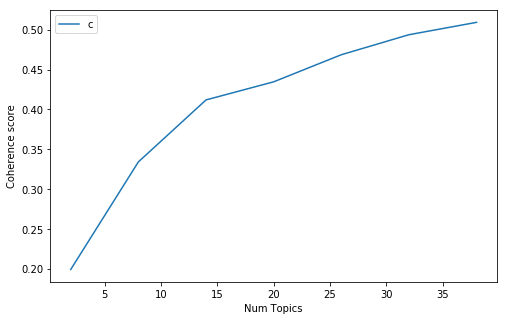

In [41]:
# Show graph
x = range(2, 40, 6)
plt.figure(figsize=(8,5))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [35]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.1992
Num Topics = 8  has Coherence Value of 0.3341
Num Topics = 14  has Coherence Value of 0.4119
Num Topics = 20  has Coherence Value of 0.4346
Num Topics = 26  has Coherence Value of 0.4686
Num Topics = 32  has Coherence Value of 0.4937
Num Topics = 38  has Coherence Value of 0.5092


In [36]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.179*"tax" + 0.083*"income" + 0.052*"live" + 0.040*"year" + 0.029*"return" '
  '+ 0.028*"state" + 0.028*"owe" + 0.026*"file" + 0.021*"benefit" + '
  '0.018*"irs"'),
 (1,
  '0.208*"job" + 0.093*"time" + 0.090*"work" + 0.064*"offer" + 0.041*"salary" '
  '+ 0.028*"week" + 0.025*"current" + 0.023*"full" + 0.021*"negotiate" + '
  '0.017*"quit"'),
 (2,
  '0.270*"car" + 0.156*"buy" + 0.123*"home" + 0.045*"mortgage" + 0.025*"worth" '
  '+ 0.022*"vehicle" + 0.017*"repair" + 0.012*"cheap" + 0.012*"buyer" + '
  '0.011*"equity"'),
 (3,
  '0.168*"question" + 0.043*"raise" + 0.030*"increase" + 0.027*"leave" + '
  '0.027*"thing" + 0.026*"apply" + 0.025*"friend" + 0.023*"people" + '
  '0.021*"happen" + 0.017*"bonus"'),
 (4,
  '0.209*"pay" + 0.068*"cash" + 0.054*"bill" + 0.051*"back" + '
  '0.046*"collection" + 0.044*"receive" + 0.026*"send" + 0.016*"free" + '
  '0.013*"service" + 0.012*"potential"'),
 (5,
  '0.190*"account" + 0.109*"bank" + 0.051*"open" + 0.051*"check" + '
  '0.029*"transfer"

In [37]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=df.title):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=df.title)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,10.0,0.0730,"payment, ira, make, amp, contribution, day, ro...",Ways to make extra side money?
1,1,17.0,0.0757,"move, rent, month, charge, apartment, fee, cos...","(Year UPDATE) Legally blind, going homeless, h..."
2,2,5.0,0.0686,"account, bank, open, check, transfer, balance,...","19, being kicked out"
3,3,5.0,0.0849,"account, bank, open, check, transfer, balance,...",Online Savings Account?
4,4,0.0,0.0648,"tax, income, live, year, return, state, owe, f...",Tools for Managing Incomes and Expenses


In [38]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index   
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.2300,"tax, income, live, year, return, state, owe, f...",Dual citizen living in Canada for 10+ years wi...
1,1.0,0.1885,"job, time, work, offer, salary, week, current,...",Currently make $14.50/hr at full time position...
2,2.0,0.1565,"car, buy, home, mortgage, worth, vehicle, repa...",My 2008 hybrid car was declared a total loss a...
3,3.0,0.1367,"question, raise, increase, leave, thing, apply...",Found a document on a work PC that outlines my...
4,4.0,0.1694,"pay, cash, bill, back, collection, receive, se...",An automatic recurring membership was billed f...
5,5.0,0.2261,"account, bank, open, check, transfer, balance,...",I made a cash deposit in a bank ATM machine. T...
6,6.0,0.2128,"budget, wife, afford, month, family, spend, mo...","Single dad w/ 4 kids, live with family for hel..."
7,7.0,0.1713,"option, investment, invest, fund, stock, good,...",Is there a significant difference between inve...
8,8.0,0.1375,"saving, retirement, plan, high, change, low, f...",Is it wise to open multiple high interest savi...
9,9.0,0.1380,"loan, student, college, pay, refinance, privat...",I have $66k in student loans. I just got a sta...


In [39]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,10.0,"payment, ira, make, amp, contribution, day, ro...",756.0,0.0742
1,17.0,"move, rent, month, charge, apartment, fee, cos...",662.0,0.0650
2,5.0,"account, bank, open, check, transfer, balance,...",760.0,0.0746
3,5.0,"account, bank, open, check, transfer, balance,...",486.0,0.0477
4,0.0,"tax, income, live, year, return, state, owe, f...",423.0,0.0415
5,12.0,"make, employer, purchase, business, expense, f...",628.0,0.0617
6,10.0,"payment, ira, make, amp, contribution, day, ro...",493.0,0.0484
7,11.0,"debt, pay, finance, personal, call, emergency_...",576.0,0.0566
8,0.0,"tax, income, live, year, return, state, owe, f...",486.0,0.0477
9,11.0,"debt, pay, finance, personal, call, emergency_...",657.0,0.0645
